Lambert Scattering

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def I_lambert(e,psi,alpha,w,F):
    curly_e = np.arcsin((e*(1+np.cos(alpha)) + (1-np.cos(alpha)))/2) # Using eqn12, converting to planetary coordinate
    eta = np.arccos(psi)
    u = np.sin(eta)*np.cos(curly_e)  # Eqn 10
    
    return w*F*u

In [16]:
def j_lambert(alpha,w,F):
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    j_total = 0
    for i in range(32):
        for j in range(32):
            #eqn 11
            j_total+= weights_c[i]*weights_l[j]*((1-(x_c[i]**2))**0.5)*I_lambert(x_c[i],x_l[j],alpha,w,F)
    
    return j_total

In [18]:
import numpy as np
A_g1 = []
w_list =np.linspace(0,1,10)   #Scattering Albedo
F=10              #Flux
for w in w_list:
    A_g1.append(j_lambert(0,w,F)/(np.pi* F))

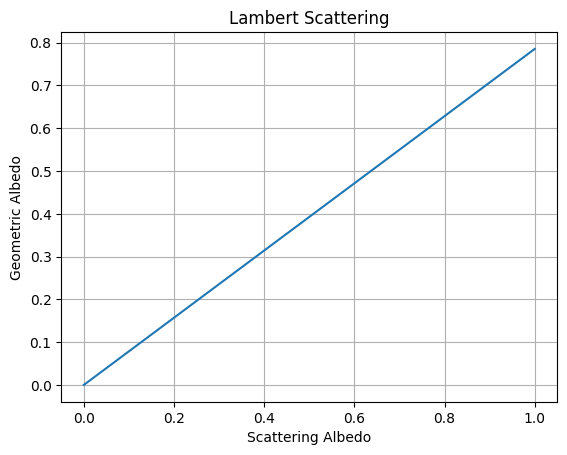

In [20]:
import matplotlib.pyplot as plt

plt.plot(w_list,A_g1)
plt.grid()
plt.xlabel("Scattering Albedo")
plt.ylabel("Geometric Albedo")
plt.title("Lambert Scattering")
plt.show()

Isotropic Scattering

In [6]:
import numpy as np

def H_input(w):
    #At the points of x_l I am trying to find the value of H so that I can use that as an input for 
    # any general u value integral using chebyshev.
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    # since sum is from 0 to 1 and not from -1 to 1 hence we will convert it to that range.  
    x_new_l = (x_l+1)/2
    x_new_c = (x_c+1)/2
    h_required = np.random.random(32) #This time I tried random initialization
    #h_required = np.ones_like(x_l)   # In this similar graph but with value of 1 stops at 0.25
    for _ in range(30):    
        for i in range(len(x_l)):                                               
            h = sum([weights_c[j]* h_required[i] * w * x_new_c[j] / (x_new_c[j] + x_new_l[i]) for j in range(32)])
            h_required[i] = 1 / (((1 - (w**2)) ** 0.5) +  h)   
            # I have replace (1-2w) with (1-(w**2)) as it can be negative and inside of root it does not make any sense
    return h_required


def H(u0,w,inputs):
    H0 = 1
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_new_l = (x_l+1)/2
    h = sum([weights_l[i]* inputs[i] * w * x_new_l[i] / (x_new_l[i] + u0) for i in range(32)])
    H0 = 1 / (((1 - (w**2)) ** 0.5) +  h)

    return H0 

In [2]:
def I_in_new_to_u(e,psi,alpha,w,F):

    curly_e = np.arcsin((e*(1+np.cos(alpha)) + (1-np.cos(alpha)))/2)
    eta = np.arccos(psi)
    u = np.sin(eta)*np.cos(curly_e)   #eqn 10
    u0 = np.sin(eta)*np.cos(curly_e-alpha)    #eqn 9
    inputs = H_input(w)
     
    H0 = H(u0,w,inputs)
    Hu = H(u,w,inputs)

    I_val = (w * F / 4) * (u0 / (u0 + u)) * Hu * H0
    
    return I_val

In [3]:
def j(alpha,w,F):
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    j_total = 0
    for i in range(32):
        for j in range(32):
            j_total+= weights_c[i]*weights_l[j]*((1-(x_c[i]**2))**0.5)*I_in_new_to_u(x_c[i],x_l[j],alpha,w,F)
    
    return j_total

In [7]:
import numpy as np
A_g_isotropic = []
w_list =np.linspace(0,1,20)
F=10
for w in w_list:
    A_g_isotropic.append(j(0,w,F)/(np.pi* F))

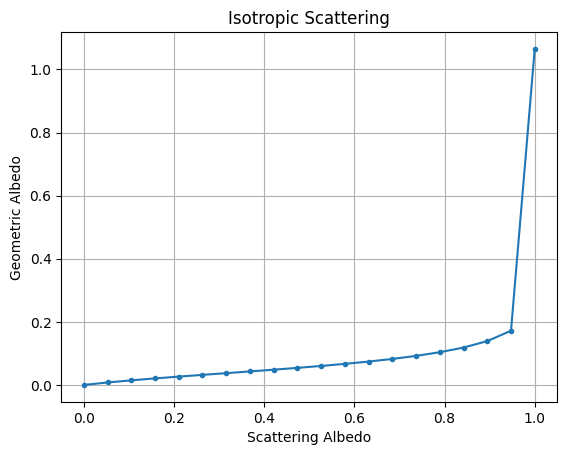

In [8]:
import matplotlib.pyplot as plt

plt.plot(w_list,A_g_isotropic,marker='.')
plt.grid()
plt.xlabel("Scattering Albedo")
plt.ylabel("Geometric Albedo")
plt.title("Isotropic Scattering")
plt.show()

Anisotropic Scattering

In [16]:
def H_input_assym(x,w,n):
    # n = 0,1 so that we can choose what we want to solve easily 
    w_simplified = [0.5*w*(1+(x*(1-w)/3)),x*w/6]    #This is different from w, it is characteristic function
                                                    # I have simplified it to use it directly
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    x_new_l = (x_l+1)/2
    x_new_c = (x_c+1)/2
    h_required = np.ones_like(x_l)  #initialization
    fn = [0.5*w*(1+(x*(1-w)*(x_new_c**2))),(x*w*(1-((x_new_c)**2)))]
    for _ in range(10):    
        for i in range(len(x_l)):     
            #eqn 17                                          
            h = sum([weights_c[j]* h_required[i] * fn[n][j] * x_new_c[j] / (x_new_c[j] + x_new_l[j]) for j in range(32)])
            h_required[i] = 1 / (((1 - (2 * w_simplified[n])) ** 0.5) +  h)   
    
    return h_required

def H_assym(x,w,u,n):
    inputs = H_input_assym(x,w,n)
    H0 = 1
    w_simplified = [0.5*w*(1+(x*(1-w)/3)),x*w/6]   
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_new_c = (x_l+1)/2
    fn = [0.5*w*(1+(x*(1-w)*(x_new_c**2))),(x*w*(1-((x_new_c)**2)))]
    for _ in range(10):
        h = sum([weights_l[i]* inputs[i] * fn[n][i] * x_new_c[i] / (x_new_c[i] + u)  for i in range(32)])
        H0 = 1 / (((1 - (2 * w_simplified[n])) ** 0.5) +  h)

    return H0 

In [17]:
def moment_0_1(x,w):
    h_required = H_input_assym(x,w,0)
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    zeroth_order = sum([weights_l[j]* h_required[j] for j in range(32)]) 
    first_order = sum([weights_l[j]*((x_l[j]+1)/2)*h_required[j] for j in range(32)]) 
    
    return [zeroth_order,first_order]

In [21]:
def I_asymmetric(e,psi,phi,phi0,alpha,w,F,x):
    curly_e = np.arcsin((e*(1+np.cos(alpha)) + (1-np.cos(alpha)))/2)
    eta = np.arccos(psi)
    
    u = np.sin(eta)*np.cos(curly_e)
    u0 = np.sin(eta)*np.cos(curly_e-alpha)

    H = H_assym(x,w,u,0)
    H0 = H_assym(x,w,u0,0)
    H_1 = H_assym(x,w,u,1)
    H0_1 = H_assym(x,w,u0,1)
    
    a0,a1 = moment_0_1(x,w) #Zeroth and first order moment of H between 0 to 1 
    c = x*w*(1-w)*a1/(2-(w*a0)+ 1e-10)
    q = 2*(1-w)/(2-(w*a0) + 1e-10)
    I = (w*F/4)*(u0/(u0+u))*( ((H*(1-(c*u)))*(H0*(1-(c*u0)))) - (x*q*q*u*u0*H*H0) + x*(((1-(u**2))*(1-(u0**2)))**0.5)*H_1*H0_1*np.cos(phi-phi0))
    
    return I

In [19]:
def j_assym(phi,phi0,alpha,w,F,x):
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    j_total = 0
    for i in range(32):
        for j in range(32):
            j_total+= weights_c[i]*weights_l[j]*((1-(x_c[i]**2))**0.5)*I_asymmetric(x_c[i],x_l[j],phi,phi0,alpha,w,F,x)
    
    return j_total

In [22]:
import numpy as np
import matplotlib.pyplot as plt

A_g_anisotropic = []
w_list =np.linspace(0,1,10)
F=10
x = 0.7
for w in w_list:
    A_g_anisotropic.append(j_assym(0,0,0,w,F,x)/(np.pi* F))

print(A_g_anisotropic)

[0.0, 0.018115651317243714, 0.03517945976258972, 0.05222729492171226, 0.07023612182303575, 0.09037046455037097, 0.11418982802034908, 0.14318524403200814, 0.1607477188359318, 1.0506454953015918]


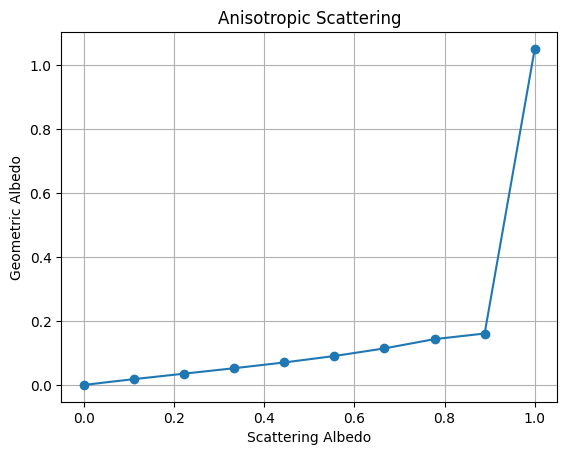

In [23]:
import matplotlib.pyplot as plt

plt.plot(w_list,A_g_anisotropic,marker='o')
plt.grid()
plt.xlabel("Scattering Albedo")
plt.ylabel("Geometric Albedo")
plt.title("Anisotropic Scattering")
plt.show()

Rayleigh Scalar Scattering

In [4]:
import numpy as np
x_l,weights_l = np.polynomial.legendre.leggauss(32)
x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
x_new_l = (x_l+1)/2
x_new_c = (x_c+1)/2

In [17]:
def H_input_rayleigh_scalar(w,n):
    w1 = [((w/20)*(11-w)),(w/20),(w/20)]   #This is different from w, it is characteristic function 
    
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    x_new_l = (x_l+1)/2
    x_new_c = (x_c+1)/2
    h_required = np.ones_like(x_new_l)
    fn = [((3/16)*w*(3-(2-w)*(x_new_c**2) - 3*(1-w)*(x_new_c**4))),((3/8)*w*((x_new_c**2) - (x_new_c**4))),((3/32)*w*((1-(x_new_c**2)**2)))]
    
    for _ in range(10):    
        for i in range(len(x_l)):                                               
            h = sum([weights_c[j]* h_required[i] * fn[n][j] * x_new_c[j] / (x_new_c[j] + x_new_l[i]) for j in range(32)])
            h_required[i] = 1 / (((1 - (2 * w1[n])) ** 0.5) +  h)   
    
    return h_required

In [18]:
def H_rayleigh_scalar(w,u0,inputs,n):
    H0 = 1
    w1_simplified = [((w/20)*(11-w)),(w/20),(w/20)]    
    
    fn = [((3/16)*w*(3-(2-w)*(x_new_l**2) - 3*(1-w)*(x_new_l**4))),((3/8)*w*((x_new_l**2) - (x_new_l**4))),((3/32)*w*((1-(x_new_l**2)**2)))]
    
    for _ in range(10):
        h = sum([weights_l[i]* H0 * fn[n][i] * inputs[i] / (inputs[i] + u0) for i in range(32)])
        H0 = 1 / (((1 - (2 * w1_simplified[n])) ** 0.5) +  h)

    return H0

In [12]:
# Function to solve the simultaneous integral equation at the quadrature points.For eqn 21 and 22.

def phi_shi_input(w,H0_input):
    phi1 = np.ones_like(x_new_l)
    shi1 = np.ones_like(x_new_l)
    for _ in range(40):
        for i in range(len(x_l)):
            int_phi1 = sum( [ weights_l[j] *(x_new_l[i]**2) * H0_input[j] * ( (x_new_l[i]*x_new_l[j]*phi1[i]*phi1[j]) + ((3+shi1[i])*(3+shi1[j])/8)) / (x_new_l[j] + x_new_l[i])  for j in range(32)])
            phi1[i] = ( (x_new_l[i]/H0_input[i])+ ((w/2)*int_phi1))

            int_shi1 = sum( [ weights_l[j] *x_new_l[i] * H0_input[j] * ( (x_new_l[i]*x_new_l[j]*phi1[i]*phi1[j]) + ((3+shi1[i])*(3+shi1[j])/8))*(3 - (x_new_l[j]**2)) / (x_new_l[j] + x_new_l[i])  for j in range(32)])
            shi1[i] = (-3 + ((3-(x_new_l[i]**2))/H0_input[i]) + ((w/2)*int_shi1) )

    
    return [phi1,shi1]    




In [13]:
# Function to get solution of eqn 21 and 22.

def phi_shi(u,w,input_phi_shi,H0_input):
    input_phi,input_shi = input_phi_shi
    phi1 = 1
    shi1 = 1
    H0 = H_rayleigh_scalar(w,u,H0_input,0)   # Here also confusion is there that where H(u) is mentioned what eqn is it referring to?
    #I took H0(u) i.e zeroth superscript one
    for _ in range(20):  # Iterated 20 times rather than till convergence
        int_phi1 = sum( [ weights_l[j] *(u**2) * H0_input[j] * ( (u*x_new_l[j]*phi1*input_phi[j]) + ((3+shi1)*(3+input_shi[j])/8)) / (x_new_l[j] + u)  for j in range(32)])
        phi1 = ( (u/H0)+ ((w/2)*int_phi1))

        int_shi1 = sum( [ weights_l[j] * u * H0_input[j] * ( (u*x_new_l[j]*phi1*input_phi[j]) + ((3+shi1)*(3+input_shi[j])/8))*(3 - (x_new_l[j]**2)) / (x_new_l[j] + u)  for j in range(32)])
        shi1 = (-3 + ((3-(u**2))/H0) + ((w/2)*int_shi1) )   

    
    phi = u*H0*phi1
    shi = H0*(u+shi1)
    return [phi,shi]    




In [14]:
def I_rayleigh_scalar(e,psi,phi,phi0,alpha,w,F):
    curly_e = np.arcsin((e*(1+np.cos(alpha)) + (1-np.cos(alpha)))/2)
    eta = np.arccos(psi)
    
    u = np.sin(eta)*np.cos(curly_e)
    u0 = np.sin(eta)*np.cos(curly_e-alpha)
    
    H0_input = H_input_rayleigh_scalar(w,0)
    input_phi_shi = phi_shi_input(w,H0_input)
    a = phi_shi(u,w,input_phi_shi,H0_input)
    b = phi_shi(u0,w,input_phi_shi,H0_input)
    phi_fn_u = a[0]
    shi_fn_u = a[1]
    phi_fn_u0 = b[0]
    shi_fn_u0 = b[1]

    H1_input = H_input_rayleigh_scalar(w,1)
    H2_input = H_input_rayleigh_scalar(w,2)

    H1_u = H_rayleigh_scalar(w,u,H1_input,1)
    H1_u0 = H_rayleigh_scalar(w,u0,H1_input,1)
    H2_u = H_rayleigh_scalar(w,u,H2_input,2)
    H2_u0 = H_rayleigh_scalar(w,u0,H2_input,2)

    #equation 20
    I = w*F/4 * (u0/(u+u0)) * ((phi_fn_u*phi_fn_u0) + (shi_fn_u*shi_fn_u0/8) 
                               -1.5*u*u0*(((1-(u**2))*(1-(u0**2)))**0.5)*H1_u*H1_u0*np.cos(phi-phi0) 
                               +0.375*((1-(u**2))*(1-(u0**2)))*H2_u*H2_u0*np.cos(2*(phi-phi0)))

    return I

In [15]:
def j(alpha,w,F):
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    j_total = 0
    for i in range(32):
        for j in range(32):
            j_total+= weights_c[i]*weights_l[j]*((1-(x_c[i]**2))**0.5)*I_rayleigh_scalar(x_c[i],x_l[j],0,0,alpha,w,F)
    
    return j_total

In [19]:
import numpy as np
A_g_rs = []
w_list =np.linspace(0,1,10)
F=10
for w in w_list:
    A_g_rs.append(j(0,w,F)/(np.pi* F))

/tmp/ipykernel_85364/2840180845.py:9: RuntimeWarning: overflow encountered in double_scalars
  int_shi1 = sum( [ weights_l[j] *x_new_l[i] * H0_input[j] * ( (x_new_l[i]*x_new_l[j]*phi1[i]*phi1[j]) + ((3+shi1[i])*(3+shi1[j])/8))*(3 - (x_new_l[j]**2)) / (x_new_l[j] + x_new_l[i])  for j in range(32)])
/tmp/ipykernel_85364/2840180845.py:6: RuntimeWarning: overflow encountered in double_scalars
  int_phi1 = sum( [ weights_l[j] *(x_new_l[i]**2) * H0_input[j] * ( (x_new_l[i]*x_new_l[j]*phi1[i]*phi1[j]) + ((3+shi1[i])*(3+shi1[j])/8)) / (x_new_l[j] + x_new_l[i])  for j in range(32)])


In [20]:
A_g_rs

[0.0,
 0.004519671574401079,
 0.012718657263581094,
 0.030891374406538972,
 0.09975018522850855,
 inf,
 inf,
 inf,
 inf,
 inf]

Rayleigh Vector Scattering

In [9]:
import numpy as np

x_l,weights_l = np.polynomial.legendre.leggauss(32)
x_new = (x_l+1)/2
epsilon = 1e-10

def M(u):
    M1 = np.array([[u**2,(2**0.5)*(1-(u**2))],[1,0]])* (3**0.5)/2
    return M1

def H_input_rayleigh_vector(w,n):
    #n=1,2,3
    w1 = [(w/10),(9*w/40)]   #Simplified the integral of characteristic function
    
    h_required = np.ones_like(x_new)
    
    fn = [((3/8)*w*( (1-(x_new**2)) - (1+(2*(x_new**2))) ) ),((3/16)*w*((1+(x_new**2))**2))]
    
    for _ in range(10):    
        for i in range(len(x_l)):                                               
            h = sum([weights_l[j]* h_required[i] * fn[n-1][j] * x_new[j] / (x_new[j] + x_new[i]+ epsilon) for j in range(32)])
            h_required[i] = 1 / (((1 - (2 * w1[n-1])) ** 0.5) +  h)   
    
    return h_required


def H_rayleigh_vector(w,u0,inputs,n):
    H0 = 1
    w1_simplified = [(w/10),(9*w/40)]     
    fn = [((3/8)*w*( (1-(x_new**2)) - (1+(2*(x_new**2))) ) ),((3/16)*w*((1+(x_new**2))**2))]
    
    for _ in range(10):
        h = sum([weights_l[i]* H0 * fn[n-1][i] * inputs[i] / (inputs[i] + u0 + epsilon) for i in range(32)])
        H0 = 1 / (((1 - (2 * w1_simplified[n-1])) ** 0.5) +  h)

    return H0    

def N(w,u):
    N_matrix = M(u)
    for _ in range(20):
        integral = sum([weights_l[i]* np.matmul(N_matrix.T,M(x_new[i])) * x_new[i] / (x_new[i] + u + epsilon) for i in range(32)])
        N_matrix = M(u) + 0.5*w*u*np.matmul(N_matrix,integral)
    return N_matrix    

In [11]:
def I_rayleigh_vector(e,psi,phi,phi0,alpha,w,F):
    curly_e = np.arcsin((e*(1+np.cos(alpha)) + (1-np.cos(alpha)))/2)
    eta = np.arccos(psi)
    
    u = np.sin(eta)*np.cos(curly_e)
    u0 = np.sin(eta)*np.cos(curly_e-alpha)
    
    N1 = N(w,u)
    N0 = N(w,u0)
    inputs1 = H_input_rayleigh_vector(w,1)
    inputs2 = H_input_rayleigh_vector(w,2)
    A = (N1[0,0]+N1[1,0])*(N0[0,0]+N0[1,0])  + (N1[0,1]+N1[1,1])*(N0[0,1]+N0[1,1])
    B = -3*u*u0*((1-(u**2))**0.5)*((1-(u0**2))**0.5)*H_rayleigh_vector(w,u,inputs1,1)*H_rayleigh_vector(w,u0,inputs1,1)
    C = 0.75*(1-(u**2))*(1-(u0**2))*H_rayleigh_vector(w,u,inputs2,2)*H_rayleigh_vector(w,u0,inputs2,2)
    D = 1/(8*(u+u0))

    I = w*D*u0*F*(A+B*np.cos(phi0-phi) + C*np.cos(2*(phi0-phi)))
    return I

In [12]:
def j(alpha,w,F):
    x_l,weights_l = np.polynomial.legendre.leggauss(32)
    x_c,weights_c = np.polynomial.chebyshev.chebgauss(32)
    j_total = 0
    for i in range(32):
        for j in range(32):
            j_total+= weights_c[i]*weights_l[j]*((1-(x_c[i]**2))**0.5)*I_rayleigh_vector(x_c[i],x_l[j],0,0,alpha,w,F)
    
    return j_total

In [13]:
import numpy as np
A_g_rv = []
w_list =np.linspace(0,1,10)
F=10
for w in w_list:
    A_g_rv.append(j(0,w,F)/(np.pi* F))

print(A_g_rv)

/tmp/ipykernel_219495/4166859119.py:12: RuntimeWarning: overflow encountered in double_scalars
  A = (N1[0,0]+N1[1,0])*(N0[0,0]+N0[1,0])  + (N1[0,1]+N1[1,1])*(N0[0,1]+N0[1,1])
/tmp/ipykernel_219495/1010100922.py:41: RuntimeWarning: overflow encountered in matmul
  N_matrix = M(u) + 0.5*w*u*np.matmul(N_matrix,integral)
/tmp/ipykernel_219495/1010100922.py:40: RuntimeWarning: invalid value encountered in matmul
  integral = sum([weights_l[i]* np.matmul(N_matrix.T,M(x_new[i])) * x_new[i] / (x_new[i] + u + epsilon) for i in range(32)])
/tmp/ipykernel_219495/1010100922.py:41: RuntimeWarning: invalid value encountered in matmul
  N_matrix = M(u) + 0.5*w*u*np.matmul(N_matrix,integral)


[0.0, 0.018466733923174033, 0.037599130288742184, 0.055662426354801606, -750.4384322380207, 0.1459256321671535, -128.0657179400384, 262466511913298.53, nan, nan]


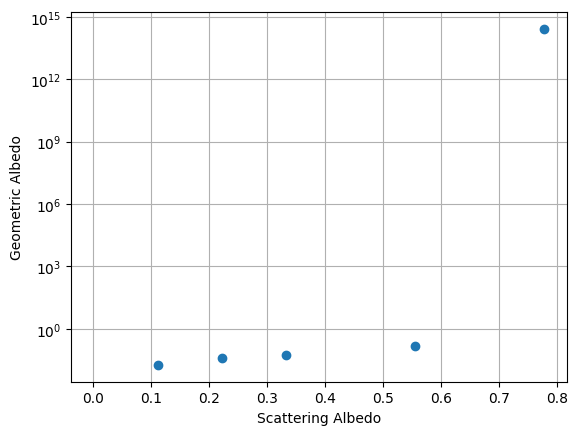

In [36]:
#I got completely garbage result

import matplotlib.pyplot as plt

plt.scatter(w_list,A_g_rv,marker='o')
plt.xlabel("Scattering Albedo")
plt.ylabel("Geometric Albedo")
plt.yscale("log")
plt.grid()